In [ ]:
import nbformat

# Read the notebook
with open('your_notebook.ipynb', 'r') as f:
    nb = nbformat.read(f, as_version=4)

# Remove widget metadata
if 'widgets' in nb.metadata:
    del nb.metadata['widgets']

# Save the cleaned notebook
with open('your_notebook.ipynb', 'w') as f:
    nbformat.write(nb, f)

In [1]:
%%capture
# Install Unsloth and dependencies
# The %%capture magic prevents installation output from cluttering the notebook
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes

In [2]:
import torch

print(f"GPU Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    # BF16 (Brain Float 16) is a special number format that uses less memory while maintaining accuracy
    print(f"BF16 Support: {torch.cuda.is_bf16_supported()}")

GPU Available: True
GPU Name: Tesla T4
GPU Memory: 14.74 GB
BF16 Support: True


In [3]:
from unsloth import FastLanguageModel
import torch

# Configuration parameters
max_seq_length = 2048  # How many tokens (roughly words) the model can see at once
dtype = None  # Let Unsloth choose the best precision format automatically
load_in_4bit = True  # Compress model to save 70% memory - this is Unsloth's magic!

# Load model and tokenizer
# Unsloth's FastLanguageModel automatically optimizes the loading process
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/smollm2-135m",  # A small 135M parameter model, good for learning
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,  # Enables QLoRA (Quantized LoRA)
)

print(f"âœ“ Model loaded: {model.config._name_or_path}")
print(f"âœ“ Total parameters: {model.num_parameters():,}")
# 135M parameters means 135 million trainable numbers in the neural network

ðŸ¦¥ Unsloth: Will patch your computer to enable 2x faster free finetuning.
ðŸ¦¥ Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.11.2: Fast Llama patching. Transformers: 4.57.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/158 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/742 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

âœ“ Model loaded: unsloth/smollm2-135m
âœ“ Total parameters: 134,515,584


In [4]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 256,  # LoRA rank - higher means more expressive adapters (but more memory)
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",  # Attention layers
        "gate_proj", "up_proj", "down_proj",      # Feed-forward layers
        "lm_head", "embed_tokens"                 # Input/output layers (for full fine-tuning)
    ],
    lora_alpha = 256,  # Scaling factor (usually set to rank or 2*rank)
    lora_dropout = 0,  # No dropout for small models
    bias = "none",     # Don't train bias terms (saves memory)
    use_gradient_checkpointing = "unsloth",  # Unsloth's optimized checkpointing (saves 30% memory)
    random_state = 3407,  # Random seed for reproducibility
    use_rslora = False,   # Rank-stabilized LoRA (not needed for this example)
)

# Count how many parameters we're actually training
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = model.num_parameters()

print(f"\nâœ“ LoRA Applied (Full Fine-tuning)")
print(f"  Trainable params: {trainable_params:,}")
print(f"  Total params: {total_params:,}")
print(f"  Trainable %: {trainable_params/total_params*100:.2f}%")
print(f"  LoRA Rank: 256")
print(f"  LoRA Alpha: 256")

Unsloth: Offloading input_embeddings to disk to save VRAM
Unsloth: Offloading output_embeddings to disk to save VRAM


Unsloth 2025.11.2 patched 30 layers with 30 QKV layers, 30 O layers and 30 MLP layers.


Unsloth: Training embed_tokens in mixed precision to save VRAM
Unsloth: Training lm_head in mixed precision to save VRAM

âœ“ LoRA Applied (Full Fine-tuning)
  Trainable params: 134,775,936
  Total params: 297,603,648
  Trainable %: 45.29%
  LoRA Rank: 256
  LoRA Alpha: 256


In [5]:
from datasets import load_dataset

# Load a small subset of the CodeParrot dataset
# The dataset is hosted on HuggingFace's dataset hub
print("Loading dataset...")
dataset = load_dataset(
    "codeparrot/codeparrot-clean",  # Clean, deduplicated version
    split="train[:1000]",            # Take only first 1000 examples (out of millions)
    trust_remote_code=True           # Allow custom loading code
)

print(f"\nâœ“ Dataset loaded: {len(dataset)} samples")
print(f"  Fields: {dataset.column_names}")

# Show a sample to understand the data format
print(f"\nSample code snippet:")
print("-" * 80)
print(dataset[0]['content'][:200])  # Print first 200 characters of code
print("-" * 80)

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'codeparrot/codeparrot-clean' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
ERROR:datasets.load:`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'codeparrot/codeparrot-clean' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Loading dataset...


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/54 [00:00<?, ?it/s]

file-000000000001.json.gz:   0%|          | 0.00/246M [00:00<?, ?B/s]

file-000000000002.json.gz:   0%|          | 0.00/248M [00:00<?, ?B/s]

file-000000000003.json.gz:   0%|          | 0.00/247M [00:00<?, ?B/s]

file-000000000004.json.gz:   0%|          | 0.00/247M [00:00<?, ?B/s]

file-000000000005.json.gz:   0%|          | 0.00/247M [00:00<?, ?B/s]

file-000000000006.json.gz:   0%|          | 0.00/246M [00:00<?, ?B/s]

file-000000000007.json.gz:   0%|          | 0.00/246M [00:00<?, ?B/s]

file-000000000008.json.gz:   0%|          | 0.00/248M [00:00<?, ?B/s]

file-000000000009.json.gz:   0%|          | 0.00/245M [00:00<?, ?B/s]

file-000000000010.json.gz:   0%|          | 0.00/245M [00:00<?, ?B/s]

file-000000000011.json.gz:   0%|          | 0.00/244M [00:00<?, ?B/s]

file-000000000012.json.gz:   0%|          | 0.00/243M [00:00<?, ?B/s]

file-000000000013.json.gz:   0%|          | 0.00/245M [00:00<?, ?B/s]

file-000000000014.json.gz:   0%|          | 0.00/242M [00:00<?, ?B/s]

file-000000000015.json.gz:   0%|          | 0.00/243M [00:00<?, ?B/s]

file-000000000016.json.gz:   0%|          | 0.00/240M [00:00<?, ?B/s]

file-000000000017.json.gz:   0%|          | 0.00/242M [00:00<?, ?B/s]

file-000000000018.json.gz:   0%|          | 0.00/242M [00:00<?, ?B/s]

file-000000000019.json.gz:   0%|          | 0.00/241M [00:00<?, ?B/s]

file-000000000020.json.gz:   0%|          | 0.00/242M [00:00<?, ?B/s]

file-000000000021.json.gz:   0%|          | 0.00/236M [00:00<?, ?B/s]

file-000000000022.json.gz:   0%|          | 0.00/238M [00:00<?, ?B/s]

file-000000000023.json.gz:   0%|          | 0.00/240M [00:00<?, ?B/s]

file-000000000024.json.gz:   0%|          | 0.00/237M [00:00<?, ?B/s]

file-000000000025.json.gz:   0%|          | 0.00/238M [00:00<?, ?B/s]

file-000000000026.json.gz:   0%|          | 0.00/237M [00:00<?, ?B/s]

file-000000000027.json.gz:   0%|          | 0.00/238M [00:00<?, ?B/s]

file-000000000028.json.gz:   0%|          | 0.00/239M [00:00<?, ?B/s]

file-000000000029.json.gz:   0%|          | 0.00/238M [00:00<?, ?B/s]

file-000000000030.json.gz:   0%|          | 0.00/239M [00:00<?, ?B/s]

file-000000000031.json.gz:   0%|          | 0.00/237M [00:00<?, ?B/s]

file-000000000032.json.gz:   0%|          | 0.00/239M [00:00<?, ?B/s]

file-000000000033.json.gz:   0%|          | 0.00/236M [00:00<?, ?B/s]

file-000000000034.json.gz:   0%|          | 0.00/237M [00:00<?, ?B/s]

file-000000000035.json.gz:   0%|          | 0.00/235M [00:00<?, ?B/s]

file-000000000036.json.gz:   0%|          | 0.00/236M [00:00<?, ?B/s]

file-000000000037.json.gz:   0%|          | 0.00/234M [00:00<?, ?B/s]

file-000000000038.json.gz:   0%|          | 0.00/235M [00:00<?, ?B/s]

file-000000000039.json.gz:   0%|          | 0.00/234M [00:00<?, ?B/s]

file-000000000040.json.gz:   0%|          | 0.00/234M [00:00<?, ?B/s]

file-000000000041.json.gz:   0%|          | 0.00/235M [00:00<?, ?B/s]

file-000000000042.json.gz:   0%|          | 0.00/236M [00:00<?, ?B/s]

file-000000000043.json.gz:   0%|          | 0.00/236M [00:00<?, ?B/s]

file-000000000044.json.gz:   0%|          | 0.00/234M [00:00<?, ?B/s]

file-000000000045.json.gz:   0%|          | 0.00/237M [00:00<?, ?B/s]

file-000000000046.json.gz:   0%|          | 0.00/234M [00:00<?, ?B/s]

file-000000000047.json.gz:   0%|          | 0.00/232M [00:00<?, ?B/s]

file-000000000048.json.gz:   0%|          | 0.00/232M [00:00<?, ?B/s]

file-000000000049.json.gz:   0%|          | 0.00/233M [00:00<?, ?B/s]

file-000000000050.json.gz:   0%|          | 0.00/234M [00:00<?, ?B/s]

file-000000000051.json.gz:   0%|          | 0.00/233M [00:00<?, ?B/s]

file-000000000052.json.gz:   0%|          | 0.00/234M [00:00<?, ?B/s]

file-000000000053.json.gz:   0%|          | 0.00/230M [00:00<?, ?B/s]

file-000000000054.json.gz:   0%|          | 0.00/142M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]


âœ“ Dataset loaded: 1000 samples
  Fields: ['repo_name', 'path', 'copies', 'size', 'content', 'license', 'hash', 'line_mean', 'line_max', 'alpha_frac', 'autogenerated']

Sample code snippet:
--------------------------------------------------------------------------------
###############################################################################
##
##  Copyright (C) 2013-2014 Tavendo GmbH
##
##  Licensed under the Apache License, Version 2.0 (the "License");
##  y
--------------------------------------------------------------------------------


In [6]:
from transformers import TrainingArguments
from trl import SFTTrainer  # Supervised Fine-Tuning Trainer
import os

# Create directory to save model checkpoints
output_dir = "./checkpoints/colab1"
os.makedirs(output_dir, exist_ok=True)

# Configure all training hyperparameters
training_args = TrainingArguments(
    # Batch size configuration
    per_device_train_batch_size = 2,  # How many examples per GPU
    gradient_accumulation_steps = 4,   # Simulate larger batches (2Ã—4=8 effective batch size)

    # Learning rate schedule
    warmup_steps = 10,         # Warm up learning rate gradually
    max_steps = 100,           # Total number of training steps
    learning_rate = 2e-4,      # Step size for parameter updates (0.0002)
    lr_scheduler_type = "linear",  # Gradually decrease learning rate

    # Precision (speed & memory optimization)
    fp16 = not torch.cuda.is_bf16_supported(),  # Use FP16 if BF16 unavailable
    bf16 = torch.cuda.is_bf16_supported(),      # Brain Float 16 (better for training)

    # Optimizer configuration
    optim = "adamw_8bit",     # Unsloth's 8-bit Adam optimizer (saves memory)
    weight_decay = 0.01,      # Prevent overfitting by penalizing large weights

    # Logging and saving
    logging_steps = 5,        # Log metrics every 5 steps
    save_strategy = "steps",  # Save checkpoints periodically
    save_steps = 50,          # Save every 50 steps
    output_dir = output_dir,  # Where to save checkpoints
    report_to = "none",       # Don't use external logging (WandB, TensorBoard)

    # Reproducibility
    seed = 3407,              # Random seed for consistent results
)

print("âœ“ Training configuration:")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Gradient accumulation: {training_args.gradient_accumulation_steps}")
print(f"  Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"  Max steps: {training_args.max_steps}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Optimizer: {training_args.optim}")

âœ“ Training configuration:
  Batch size: 2
  Gradient accumulation: 4
  Effective batch size: 8
  Max steps: 100
  Learning rate: 0.0002
  Optimizer: OptimizerNames.ADAMW_8BIT


In [9]:
# Define a formatting function
def formatting_func(examples):
    texts = []
    for content in examples["content"]:
        # Format the content as needed for your model
        # For this case, we'll just use the content as is
        texts.append(content)
    return texts # Return the list of strings directly


# Initialize SFTTrainer (Supervised Fine-Tuning Trainer)
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "content",  # Field containing code
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,  # Can make training 5x faster for short sequences
    args = training_args,
    formatting_func=formatting_func, # Add the formatting function back
)

print("\n" + "="*80)
print("STARTING TRAINING - FULL FINE-TUNING")
print("="*80)

# Monitor GPU memory before training
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    print(f"\nGPU Memory before training: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

# Train the model
trainer_stats = trainer.train()


# Monitor GPU memory after training
if torch.cuda.is_available():
    print(f"\nGPU Memory after training: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
    print(f"Peak GPU Memory: {torch.cuda.max_memory_allocated()/1024**3:.2f} GB")

print("\n" + "="*80)
print("TRAINING COMPLETED")
print("="*80)

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/1000 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.



STARTING TRAINING - FULL FINE-TUNING

GPU Memory before training: 0.56 GB


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 2
   \\   /|    Num examples = 1,000 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 134,775,936 of 297,603,648 (45.29% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
5,1.648100
10,1.604700
15,1.742300
20,1.570100
25,1.581800
30,1.489700
35,1.475700
40,1.619300
45,1.567600
50,1.460100



GPU Memory after training: 0.99 GB
Peak GPU Memory: 2.12 GB

TRAINING COMPLETED



Training Statistics:
 step   loss  learning_rate
    5 1.6481       0.000080
   10 1.6047       0.000180
   15 1.7423       0.000191
   20 1.5701       0.000180
   25 1.5818       0.000169
   30 1.4897       0.000158
   35 1.4757       0.000147
   40 1.6193       0.000136
   45 1.5676       0.000124
   50 1.4601       0.000113
   55 1.4970       0.000102
   60 1.4578       0.000091
   65 1.5386       0.000080
   70 1.4213       0.000069
   75 1.5690       0.000058
   80 1.3472       0.000047
   85 1.5620       0.000036
   90 1.4804       0.000024
   95 1.4606       0.000013
  100 1.5393       0.000002


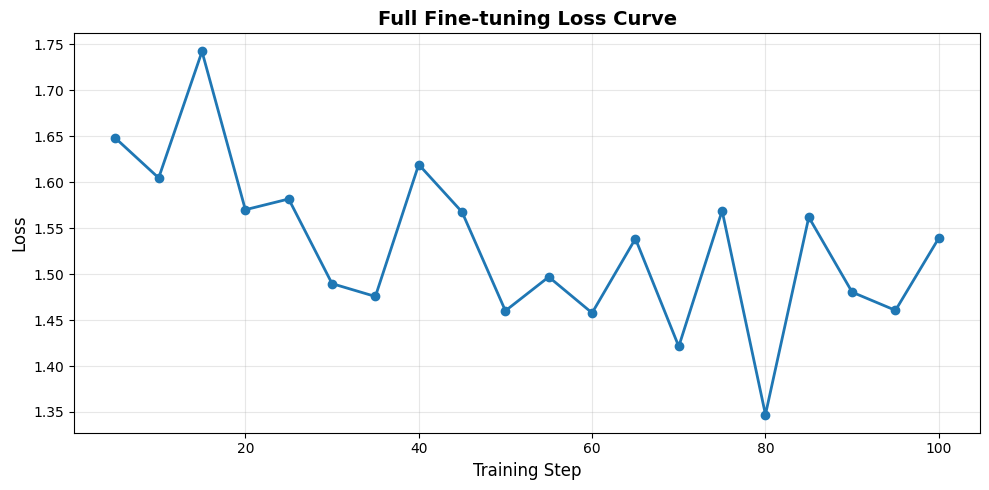


âœ“ Loss curve saved to ./checkpoints/colab1/loss_curve.png

Final Training Statistics:
  Total steps: 100
  Final loss: 1.5393
  Average loss: 1.5316
  Training time: 313.09 seconds
  Samples/second: 2.56


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract training logs
logs = trainer.state.log_history
train_logs = [log for log in logs if 'loss' in log]

# Create DataFrame
df = pd.DataFrame(train_logs)
print("\nTraining Statistics:")
print(df[['step', 'loss', 'learning_rate']].to_string(index=False))

# Plot loss curve
if len(df) > 0:
    plt.figure(figsize=(10, 5))
    plt.plot(df['step'], df['loss'], marker='o', linewidth=2)
    plt.xlabel('Training Step', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Full Fine-tuning Loss Curve', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/loss_curve.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nâœ“ Loss curve saved to {output_dir}/loss_curve.png")

# Print final statistics
print(f"\nFinal Training Statistics:")
print(f"  Total steps: {trainer.state.global_step}")
print(f"  Final loss: {df['loss'].iloc[-1]:.4f}")
print(f"  Average loss: {df['loss'].mean():.4f}")
print(f"  Training time: {trainer_stats.metrics['train_runtime']:.2f} seconds")
print(f"  Samples/second: {trainer_stats.metrics['train_samples_per_second']:.2f}")

In [11]:
FastLanguageModel.for_inference(model)

# Test prompts
test_prompts = [
    "def fibonacci(n):",
    "class DataProcessor:",
    "import numpy as np\n\ndef calculate_mean(",
]

print("\n" + "="*80)
print("CODE GENERATION SAMPLES")
print("="*80)

for i, prompt in enumerate(test_prompts, 1):
    print(f"\n--- Sample {i} ---")
    print(f"Prompt: {prompt}")
    print("\nGenerated Code:")
    print("-" * 80)

    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    outputs = model.generate(
        **inputs,
        max_new_tokens = 128,
        temperature = 0.7,
        top_p = 0.9,
        do_sample = True,
        use_cache = True,
    )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(generated_text)
    print("-" * 80)


CODE GENERATION SAMPLES

--- Sample 1 ---
Prompt: def fibonacci(n):

Generated Code:
--------------------------------------------------------------------------------
def fibonacci(n):
    if n < 1:
        return 0
    return fibonacci(n - 1) + fibonacci(n - 2)

def fib(n):
    return fibonacci(n)

def fib_fib(n):
    return fibonacci(n)

def fib_fib_fib(n):
    return fibonacci(n)

def fib_fib_fib_fib(n):
    return fibonacci(n)

def fib_fib_fib_fib_fib(n):
    return fibonacci(n)

def fib_fib_fib
--------------------------------------------------------------------------------

--- Sample 2 ---
Prompt: class DataProcessor:

Generated Code:
--------------------------------------------------------------------------------
class DataProcessor:

    def __init__(self, input_data, output_data):
        self.input_data = input_data
        self.output_data = output_data
        self.input_data.data = data

        self.output_data.data = data

        self.output_data.output = output_data
 

In [12]:
lora_path = f"{output_dir}/lora_adapter"
model.save_pretrained(lora_path)
tokenizer.save_pretrained(lora_path)
print(f"âœ“ LoRA adapter saved to {lora_path}")

# Save merged 16-bit model (optional, larger file)
merged_path = f"{output_dir}/merged_16bit"
model.save_pretrained_merged(merged_path, tokenizer, save_method="merged_16bit")
print(f"âœ“ Merged 16-bit model saved to {merged_path}")

print("\nâœ“ All checkpoints saved successfully!")

âœ“ LoRA adapter saved to ./checkpoints/colab1/lora_adapter
Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...


Unsloth: Copying 1 files from cache to `./checkpoints/colab1/merged_16bit`: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1/1 [00:04<00:00,  4.68s/it]


Successfully copied all 1 files from cache to `./checkpoints/colab1/merged_16bit`
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Merging weights into 16bit: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1/1 [00:11<00:00, 11.12s/it]


Unsloth: Merge process complete. Saved to `/content/checkpoints/colab1/merged_16bit`
âœ“ Merged 16-bit model saved to ./checkpoints/colab1/merged_16bit

âœ“ All checkpoints saved successfully!
